In [1]:
import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

domain = "www.reddit.com/" # <- put your domain to be crawled
full_url = "https://www.reddit.com/" # <- put your domain to be crawled with https or http

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

In [2]:
# Function to get the hyperlinks from a URL
def get_hyperlinks(url):

    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []

            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

In [3]:
# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))

In [4]:
def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    q_limit = 10
    count = 0
    while queue:
        if count==q_limit:
            break
        count += 1
        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w", encoding="UTF-8") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")

            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

crawl(full_url)

https://www.reddit.com/
https://www.reddit.com/r/books
https://www.reddit.com/r/HomeworkHelp
https://www.reddit.com/r/HomeworkHelp/?f=flair_name%3A%22%3Asnoo_simple_smile%3A%20Literature%22
https://www.reddit.com/r/HomeworkHelp/comments/1fqu7k6/a_level_english_literature_othello_help
https://www.reddit.com/user/Comfortable_Elk4698
https://www.reddit.com/r/IBO/comments/1fr5hq4/help_in_analyzing_to_my_friends_by_wislawa
https://www.reddit.com/best/communities/15/#t5_2s05l
https://www.reddit.com/r/VRGaming
https://www.reddit.com/user/MoodMasterMiley


In [5]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [6]:
import pandas as pd

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r", encoding="UTF-8") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

,fname,text
0,com,com . Reddit - Dive into anything S...
1,com r books,com r books. Reddit - Dive into anything ...
2,com user MoodMasterMiley,com user MoodMasterMiley. Reddit - Dive into ...
3,com r IBO comments 1fr5hq4 help in analyzing t...,com r IBO comments 1fr5hq4 help in analyzing t...
4,com r HomeworkHelp comments 1fqu7k6 a level en...,com r HomeworkHelp comments 1fqu7k6 a level en...


<Axes: >

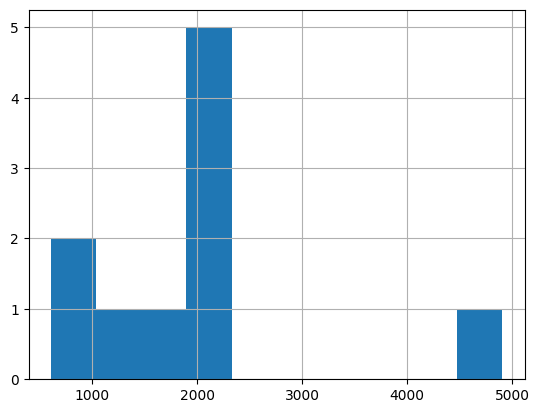

In [7]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [8]:
max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]

    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks


shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])

    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

<Axes: >

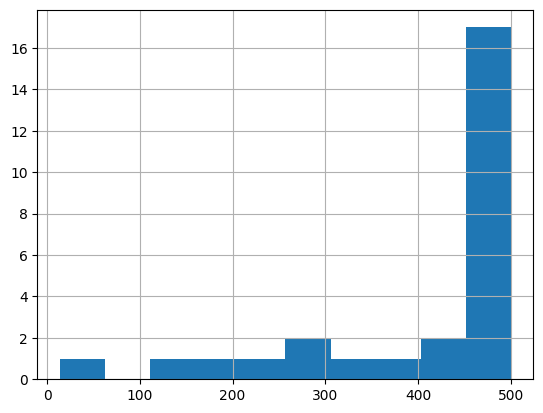

In [9]:
df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [10]:
print (df)

                                                 text  n_tokens
0   com .  Reddit - Dive into anything           S...       435
1     r/BeAmazed   r/BeAmazed      I bet you will ...       239
2   com r books.  Reddit - Dive into anything     ...       487
3   It’s like he has no empathy for his female cha...       482
4   Posts asking users to list their favorite/the ...       477
5   Please note: shallow posts are not allowed but...       116
6   com user MoodMasterMiley.  Reddit - Dive into ...       493
7   If you have raft support bring both a dry suit...       496
8   The flagship event, EDC Las Vegas, is a 3 nigh...       494
9    MoodMasterMiley      commented    They are al...       163
10  com r IBO comments 1fr5hq4 help in analyzing t...       411
11  com r HomeworkHelp comments 1fqu7k6 a level en...       257
12  com r HomeworkHelp.  Reddit - Dive into anythi...       483
13  https://preview.redd.it/calculus-1-derivatives...       497
14          This includes quizzes or lis

In [19]:
import openai
import os

# Load environment variables from the .env file
with open("/Users/jubaidatasnim/openAI/openai-quickstart-python/.env") as env:
    for line in env:
        key, value = line.strip().split("=")
        os.environ[key] = value

# Set the OpenAI API key from environment variables

openai.api_key = os.getenv('API_KEY')
#openai.api_key = api_key
# Example usage of embeddings (assuming you have a DataFrame called df)
df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])

# Save the embeddings to a CSV file
df.to_csv('processed/embeddings.csv')

# Display the first few rows
df.head()


,text,n_tokens,embeddings
0,u newsroom. Newsroom | San Francisco Bay ...,486,"[0.009192430414259434, -0.0158552136272192, 0...."
1,u ?page=0. San Francisco Bay University |...,486,"[0.009445021860301495, -0.025388220325112343, ..."
2,"Wherever you are in your education journey, we...",438,"[0.014134133234620094, -0.021065032109618187, ..."
3,u article san francisco bay university joins n...,483,"[0.004606788512319326, -0.012041709385812283, ..."
4,u article san francisco bay university appoint...,496,"[0.004910914693027735, 0.007744522299617529, -..."


In [20]:
import pandas as pd
import numpy as np
from openai.embeddings_utils import distances_from_embeddings

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

,text,n_tokens,embeddings
0,u newsroom. Newsroom | San Francisco Bay ...,486,"[0.009192430414259434, -0.0158552136272192, 0...."
1,u ?page=0. San Francisco Bay University |...,486,"[0.009445021860301495, -0.025388220325112343, ..."
2,"Wherever you are in your education journey, we...",438,"[0.014134133234620094, -0.021065032109618187, ..."
3,u article san francisco bay university joins n...,483,"[0.004606788512319326, -0.012041709385812283, ..."
4,u article san francisco bay university appoint...,496,"[0.004910914693027735, 0.007744522299617529, -..."
